<a href="https://colab.research.google.com/github/pjmartel/teaching/blob/master/enzymology/Dixon_plot_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Determinação de constantes de inibição enzimática

O presente notebook implementa duas abordagens para determinação das constantes de inibição enzimática a partir de curvas de velocidade inicial:

- Gráficos primários + Gráficos Secundários
- Gráficos de Dixon e Cornish-Bowden (determinaçaõ directa das constantes de inibição)

Os dados devem ser "colados" na célula que contem como primeira linha a expressão "%%data", no seguinte formato:
```
%%data
-1    [I]1   [I]2   [I]3  ...  [I]n
[A]1   v1     v1     v1       	v1   
[A]2   v2     v2     v2   	    v2   
[A]3   v3     v3     v3   	    v3   
[A]4   v4     v4     v4   	    v4
...   ...    ...    ...        ...
[A]n   vn     vn     vn   	    vn   
```

Em que $[A]_1 ... [A]_n$ são as concentrações de substrato, $[I]_1 ... [I]_n$ são as concentrações de inibidor e $v_1 ... v_n$ são as velocidades para cada ceontração inibidor (uma das concentrações de inibidor poderá naturalmente ser zero, indicando um ensaio sem inibidor).   
**NOTA:** o valor "-1" no canto superior esquerdo tem que estar presente. 

In [ ]:
#@title <---- Carregue em "Play"
# Import necessary modules
import numpy as np
import pandas as pd
import numpy.random as rnd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
from seaborn import regplot
from scipy.stats import linregress
from io import StringIO
from IPython.display import HTML
style.use('default')
rcParams.update({'axes.grid': True})
rcParams.update({'errorbar.capsize': 2})
pd.options.display.float_format = '{:,.3g}'.format

In [ ]:
#@title <---- Carregue em "Play"
# This creates the "data" cell magic to allow for pasted
# values to be grabbed by the running cells. That's a good
# alternative to qgrid, not yet supported by colab.
from IPython.core.magic import  (
    Magics, magics_class, cell_magic, line_magic
)

@magics_class
class StoreData(Magics):


    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._store = []
        # inject our store in user availlable namespace under __mystore
        # name
        shell.user_ns['__mystore'] = self._store

    @cell_magic
    def data(self, line, cell):
        """store the cell in the store"""
        self._store.append(cell)

    @line_magic
    def showdata(self, line):
        """show all recorded statements"""
        print(self._store)

    @line_magic
    def erasedata(self, line):
      "clear the shore"
      self._store = []

## use ipython load_ext mechanisme here if distributed
get_ipython().register_magics(StoreData)

In [ ]:
#@title <---- Carregue em Play
# Michaelis-Menten equation
def MM(K,V,s):
  return V*s/(K+s)

#### Instruções

Na célula abaixo, introduzir os valores de concentração e velocidade no seguinte formato:
```
%%data
-1    [I]1   [I]2   [I]3  ...  [I]n
[A]1   v1     v1     v1       	v1   
[A]2   v2     v2     v2   	    v2   
[A]3   v3     v3     v3   	    v3   
[A]4   v4     v4     v4   	    v4
...   ...    ...    ...        ...
[A]n   vn     vn     vn   	    vn   
```


Em que $[A]_1 ... [A]_n$ são as concentrações de substrato, $[I]_1 ... [I]_n$ são as concentrações de inibidor e $v_1 ... v_n$ são as velocidades para cada ceontração inibidor (uma das concentrações de inibidor poderá naturalmente ser zero, indicando um ensaio sem inibidor).

**NB1:** o valor "-1" no canto superior esquerdo tem que estar presente. 

**NB2:** a linha `%%data` tem que estrar presente *antes* dos dados, ou o restante código não conseguirá ler os valores intruzidos.

**NB3:** os dados podem ser introduzidos com o separador decimal *vírguala*, ou *ponto*

Após introdução dos dados carregar no botão play dessa célula e no botão play da seguinte. Deverá ser exibida uma tabela contendo os valores introduzidos.

In [ ]:
%%data
-1	0.00	0.48	1.20
1.06	7.82	7.1	5.74
2.72	13.55	11.83	10.35
4.37	18.45	16.23	12.02
6.03	21.56	17.11	13.08
7.68	24.12	18.74	14.94
9.34	24.67	20.92	15.33
10.99	27.15	21.06	15.36
12.65	28.91	21.32	16.72
14.30	29.07	23.57	16.27
15.96	31.42	24.16	17.75



In [ ]:
#@title <---- Carregue no botão "Play" para visualizar os dados introduzidos

# convert ',' decimal separator to '.'
def conv(x):
    return x.replace(',', '.').encode()

# read the above cell into a numpy array
data_np = np.genfromtxt(conv(x) for x in  StringIO(__mystore[-1])  )

# create an empy pandas data frame with the
# npoint lines and nrepl+1 columns
#
if data_np[0,0]!= -1 :
  print("""
Error: the first line (inhibitor concentrations)
must start with a -1 !")
""")
  raise KeyboardInterrupt
npoints = data_np.shape[0]
nrepl = data_np.shape[1]-1
columns = ['[A]']
columns = columns + ['[I]='+str(data_np[0,i+1]) for i in range(nrepl)]
enz_data = pd.DataFrame(data_np[1:],columns=columns)
#if nrepl > 1:
#  enz_data['Mean v']=enz_data.iloc[:,1:].mean(axis=1)
#  enz_data['Std v']=enz_data.iloc[:,1:-1].std(axis=1)
HTML(enz_data.to_html(index=False))

[A],[I]=0.0,[I]=0.48,[I]=1.2
1.06,7.82,7.1,5.74
2.72,13.6,11.8,10.3
4.37,18.4,16.2,12
6.03,21.6,17.1,13.1
7.68,24.1,18.7,14.9
9.34,24.7,20.9,15.3
11,27.1,21.1,15.4
12.7,28.9,21.3,16.7
14.3,29.1,23.6,16.3
16,31.4,24.2,17.8


Se os dados não estiverem correctos, edite a célula "%%data"  
novamente, e volte a carregar no seu botão "play" e no da célula  
 seguinte, para visualizar os dados corrigidos. 

In [ ]:
#@title 
# auxiliary functions

##
def my_textbox(vardict,x=0.55,y=0.30,ax=None):
# Place a box with the estimates
  textstr = '\n'.join(
      [(s % v) for (s,v) in vardict.items()])
    
  #textstr = '\n'.join((
  #    r'$V_{max}=%.3g$' % (ECB_Vmax, ),
  #    r'$K_m=%.3g$' % (ECB_Km, ))) 
  #    #r'$\sigma=%.2f$' % (sigma, ))))

  # these are matplotlib.patch.Patch properties
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  # place a text box in upper left in axes coords
  ax.text(x, y, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox=props)
##  
def fix_axis(ax):
  ax.spines['left'].set_position('zero')
  ax.spines['bottom'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')



#### Gráficos primários

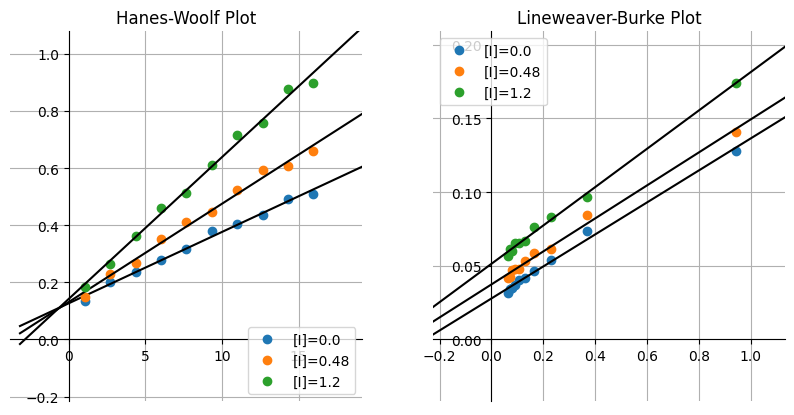

In [ ]:
#@title <---- Carregue no botão "Play" para produzir os gráficos primários

i_values = data_np[0,1:]
v_values = data_np[1:,1:]
a_values = data_np[1:,0]
v_inv = 1 / v_values
a_inv = 1 / a_values
Vmax_LB = []
Km_LB = []
Vmax_HW = []
Km_HW = []
av = np.tile(a_values,[v_values.shape[1],1]).T*v_inv
fig = plt.gcf()
fig.set_figwidth(10)
plt.subplot(1,2,1)
fx = 1.2*a_values.max()
fy = 1.2*av.max()
plt.xlim(left=-0.2*fx,right=fx)
plt.ylim(bottom=-0.2*fy,top=1.0*fy)
ax = plt.gca()
ax.set_title("Hanes-Woolf Plot")
fix_axis(ax)
for i,I in enumerate(i_values):
  plt.plot(a_values,av[:,i],'o',label="[I]="+str(I))
  m, b, r, _, _ = linregress(a_values, av[:,i])
  xx = np.arange(-3*a_values.min(),3*a_values.max(),0.01)
  plt.plot(xx, m*xx+b,'k-')
  Km_HW.append(b/m)
  Vmax_HW.append(1/m)
plt.legend(loc='lower right')

# Linweaver-Burke
plt.subplot(1,2,2)
fx = 1.2*a_inv.max()
fy = 1.2*v_inv.max()
plt.xlim(left=-0.2*fx,right=fx)
plt.ylim(bottom=-0.2*fy,top=1.0*fy)
ax = plt.gca()
ax.set_title("Lineweaver-Burke Plot")
fix_axis(ax)
for i,I in enumerate(i_values):
  plt.plot(a_inv,v_inv[:,i],'o', label="[I]="+str(I))
  m, b, r, _, _ = linregress(a_inv, v_inv[:,i])
  xx = np.arange(-3*a_values.min(),3*a_values.max(),0.01)
  plt.plot(xx, m*xx+b,'k-')
  Km_LB.append(m/b)
  Vmax_LB.append(1/b)
_ = plt.legend(loc='upper left')

Km_LB = np.array(Km_LB)
Vmax_LB = np.array(Vmax_LB)
Km_HW = np.array(Km_HW)
Vmax_HW = np.array(Vmax_HW)

#### Gráficos secundários
Variação das grandezas aparentes $K_m^{app}$ e $V_{max}^{app}$ em funcção da $[A]$. 

4.907892860525468
[-2.73717209 -2.62545078 -2.51372947 -2.40200816 -2.29028685 -2.17856554
 -2.06684423 -1.95512292 -1.84340161 -1.7316803  -1.61995899 -1.50823768
 -1.39651637 -1.28479506 -1.17307375 -1.06135244 -0.94963113 -0.83790982
 -0.72618851 -0.6144672  -0.50274589 -0.39102458 -0.27930327 -0.16758196
 -0.05586065  0.05586065  0.16758196  0.27930327  0.39102458  0.50274589
  0.6144672   0.72618851  0.83790982  0.94963113  1.06135244  1.17307375
  1.28479506  1.39651637  1.50823768  1.61995899  1.7316803   1.84340161
  1.95512292  2.06684423  2.17856554  2.29028685  2.40200816  2.51372947
  2.62545078  2.73717209]
Kic from Km(app) vs [I]: -2.7372 r=-0.981, slope=-1.7931
Kic from Km(app)/Vmax(app) vs [I]: 9.6674 r=0.99278, slope=0.013008
--- 1.205042980839229
Kiu from 1/Vmax(app) vs [I]: 1.205 r=0.9998, slope=0.020607
Kiu from 1/Km(app) vs [I]: 1.5753, r=0.9995, slope=0.12663


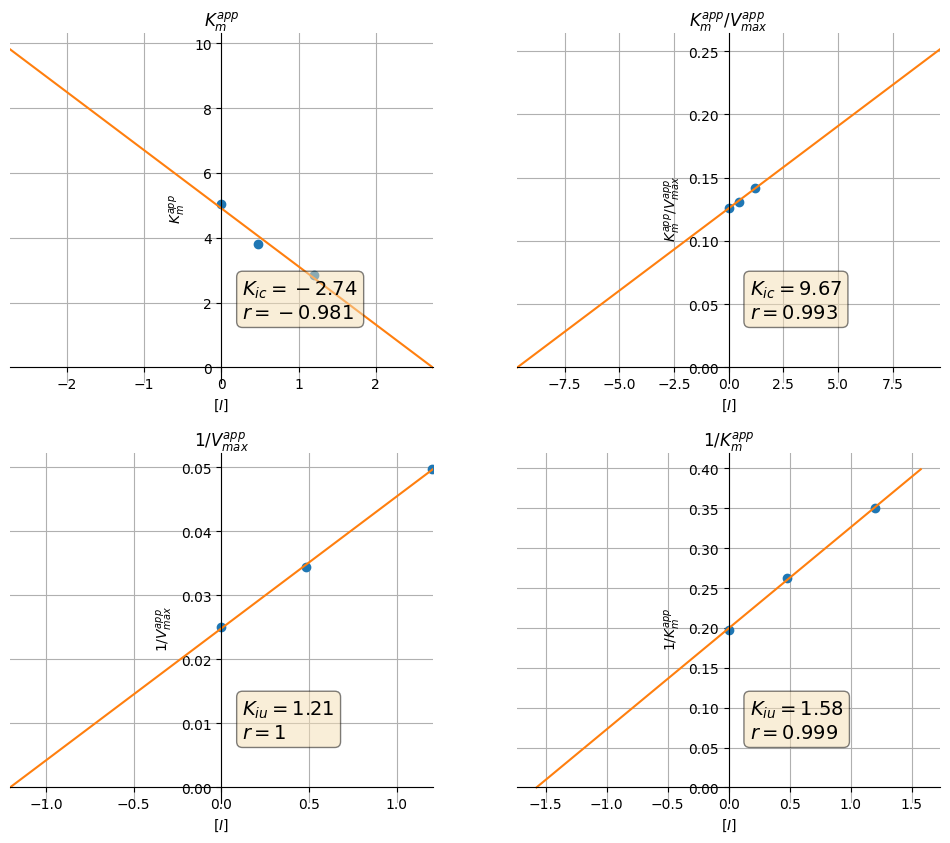

In [ ]:
#@title <---- Carregue no botão "Play" para produzir os gráficos secundários
fig, ax = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)

#
fix_axis(ax[0,0])
ax[0,0].set_title("$K_m^{app}$")
ax[0,0].set_xlabel("$[I]$")
ax[0,0].set_ylabel("$K_m^{app}$")
ax[0,0].plot(i_values, Km_HW,'o')
m, b, r, _, _ = linregress(i_values, Km_HW)
#xx = np.arange(-2*i_values.max(),2*i_values.max(),0.01)
#xx = np.arange(b/m,-b/m)
s = np.sign(m)
xx = np.linspace(min(-b/m*s, i_values.min()),max(+b/m*s,i_values.max()))
#if b < 0:
#  xx = xx[::-1]
print(b)
print(xx)
ax[0,0].set_xlim(left =-b/m*s, right=b/m*s)
ax[0,0].plot(xx, m*xx+b,'-')
my_textbox(vardict={r'$K_{ic}=%.3g$': b/m,'$r=%.3g$':r},ax=ax[0,0])
print("Kic from Km(app) vs [I]: {:.5g} r={:.5g}, slope={:.5g}".format(b/m,r,m))

#
fix_axis(ax[0,1])
ax[0,1].set_title("$K_m^{app}/V_{max}^{app}$")
ax[0,1].set_xlabel("$[I]$")
ax[0,1].set_ylabel("$K_m^{app}/V_{max}^{app}$")
ax[0,1].plot(i_values, Km_HW/Vmax_HW,'o')
m, b, r, _, _ = linregress(i_values, Km_HW/Vmax_HW)
#xx = np.arange(-1.5*i_values.max(),i_values.max(),0.01)
#xx = np.arange(-b/m,+b/m)

xx = np.linspace(min(-b/m, i_values.min()),max(+b/m,i_values.max()))
ax[0,1].set_xlim(left = -b/m,right=b/m)
ax[0,1].plot(xx, m*xx+b,'-')
my_textbox(vardict={r'$K_{ic}=%.3g$': b/m,'$r=%.3g$':r},ax=ax[0,1])
print("Kic from Km(app)/Vmax(app) vs [I]: {:.5g} r={:.5g}, slope={:.5g}".format(b/m,r,m))

#
fix_axis(ax[1,0])
ax[1,0].set_title("$1/V_{max}^{app}$")
ax[1,0].set_xlabel("$[I]$")
ax[1,0].set_ylabel("$1/V_{max}^{app}$")
ax[1,0].plot(i_values, 1/Vmax_HW,'o')
m, b, r, _, _ = linregress(i_values, 1/Vmax_HW)
xx = np.linspace(min(-b/m, i_values.min()),max(+b/m,i_values.max()))
print("---",b/m)
ax[1,0].set_xlim(left = -b/m,right=b/m)
ax[1,0].plot(xx, m*xx+b,'-')
my_textbox(vardict={r'$K_{iu}=%.3g$': b/m,'$r=%.3g$':r},ax=ax[1,0])
print("Kiu from 1/Vmax(app) vs [I]: {:.5g} r={:.5g}, slope={:.5g}".format(b/m,r,m))

#
fix_axis(ax[1,1])
ax[1,1].set_title("$1/K_m^{app}$")
ax[1,1].set_xlabel("$[I]$")
ax[1,1].set_ylabel("$1/K_m^{app}$")
ax[1,1].plot(i_values, 1/Km_HW,'o')
m, b, r, _, _ = linregress(i_values, 1/Km_HW)
#xx = np.arange(-1.5*i_values.max(),i_values.max(),0.01)
xx = np.linspace(min(-b/m, i_values.min()),max(+b/m,i_values.max()))
ax[1,1].plot(xx, m*xx+b,'-')
my_textbox(vardict={r'$K_{iu}=%.3g$': b/m,'$r=%.3g$':r},ax=ax[1,1])
#ax[1,1].set_xlim()
print("Kiu from 1/Km(app) vs [I]: {:.5g}, r={:.5g}, slope={:.5g}".format(b/m,r,m))


In [ ]:
linregress(i_values, Km_HW)

LinregressResult(slope=-1.7930523521067825, intercept=4.907892860525468, rvalue=-0.9809993985874909, pvalue=0.12429934992333498, stderr=0.3546092617828222)

In [ ]:
Km_HW, Vmax_HW, Km_HW/Vmax_HW, i_values

(array([5.05530116, 3.80154723, 2.85450224]),
 array([39.9913344 , 29.03898059, 20.1301717 ]),
 array([0.12640991, 0.13091187, 0.14180218]),
 array([0.  , 0.48, 1.2 ]))

#### Gráficos de Dixon e Cornish-Bowden

Kic from Dixon plot:  3.186
Kiu from Cornish-Bowden plot:  1.164
(values are the medians of intersections)


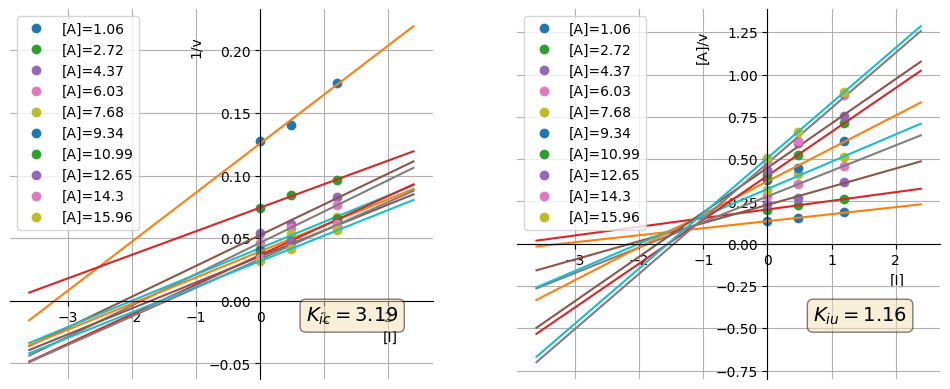

In [ ]:
#@title <--- Carregue no botão "Play" para visualizar os gráficos de Dixon e Cornish-Bowden
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(12)

# Dixon plot
mm = []
bb = []
Kic_D = []
f_D = []
for i in range(len(a_values)):
  fix_axis(ax1)
  ax1.plot(i_values, v_inv[i],'o', label="[A]="+str(a_values[i]))
  m, b, r, _, _ = linregress(i_values, v_inv[i])
  mm.append(m)
  bb.append(b)
  xx = np.arange(-3*i_values.max(),2*i_values.max(),0.01)
  ax1.plot(xx, m*xx+b,'-')
  ax1.set_xlabel("[I]",x=0.9)
  ax1.set_ylabel("1/v",y=0.9)
  ax1.legend()

# Compute intersections
for i in range(len(a_values)):
  for j in range(i):
    x = (bb[j]-bb[i])/(mm[i]-mm[j])
    y = (bb[j]*mm[i]-bb[i]*mm[j])/(mm[i]-mm[j])
    Kic_D.append(x)
    f_D.append(y)


# Cornish-Bowden
mm = []
bb = []
Kiu_CB = []
f_CB = []
for i in range(len(a_values)):
  fix_axis(ax2)
  ax2.plot(i_values, av[i],'o', label="[A]="+str(a_values[i]))
  m, b, r, _, _ = linregress(i_values, av[i])
  mm.append(m)
  bb.append(b)
  xx = np.arange(-3*i_values.max(),2*i_values.max(),0.01)
  ax2.plot(xx, m*xx+b,'-')
  ax2.legend()
  ax2.set_xlabel("[I]",x=0.9)
  ax2.set_ylabel("[A]/v",y=0.9)


# Compute intersections
for i in range(len(a_values)):
  for j in range(i):
    x = (bb[j]-bb[i])/(mm[i]-mm[j])
    y = (bb[j]*mm[i]-bb[i]*mm[j])/(mm[i]-mm[j])
    Kiu_CB.append(x)
    f_CB.append(y)
Kic_D = -np.median(Kic_D)
Kiu_CB = -np.median(Kiu_CB)
my_textbox(x=0.7,y=0.2,vardict={'$K_{ic}=%.3g$':Kic_D},ax=ax1)
my_textbox(x=0.7,y=0.2,vardict={'$K_{iu}=%.3g$':Kiu_CB},ax=ax2)
print("Kic from Dixon plot: {:6.4g}".format(Kic_D))
print("Kiu from Cornish-Bowden plot: {:6.4g}".format(Kiu_CB))
print("(values are the medians of intersections)")